# Implementing ResNets using Keras
#### The architecture used is based on the Resnet [paper](https://arxiv.org/abs/1512.03385) and will be used in creating a classification model using the CIFAR-10 dataset

#### Downloading data to drive to import it

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [3]:
%cd "/content/drive/MyDrive/kaggle/cifar"

/content/drive/MyDrive/kaggle/cifar


In [ ]:
# Download the dataset from kaggle
!kaggle competitions download -c cifar-10

In [ ]:
%ls

checkpoint  model.data-00000-of-00001  test.7z   trainLabels.csv
cifar.h5    model.index                train/    train.zip
model/      sampleSubmission.csv       train.7z


In [ ]:
import zipfile

for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)

In [ ]:
%ls

checkpoint  model.data-00000-of-00001  test/    train.7z
cifar.h5    model.index                test.7z  trainLabels.csv
model/      sampleSubmission.csv       train/   train.zip


In [ ]:
!pip install py7zr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.7 MB/s 
     |████████████████████████████████| 2.3 MB 42.0 MB/s 
     |████████████████████████████████| 93 kB 2.0 MB/s 
     |████████████████████████████████| 138 kB 61.8 MB/s 
     |████████████████████████████████| 379 kB 49.6 MB/s 
     |████████████████████████████████| 357 kB 47.2 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 


In [ ]:
import py7zr
train_file_path = '/content/drive/MyDrive/kaggle/cifar/train.7z'
archive = py7zr.SevenZipFile(train_file_path, mode='r')
archive.extractall(path='/content/drive/MyDrive/kaggle/cifar/train')
archive.close()

In [ ]:
import py7zr
test_file_path = '/content/drive/MyDrive/kaggle/cifar/test.7z'
archive = py7zr.SevenZipFile(test_file_path, mode='r')
archive.extractall(path='/content/drive/MyDrive/kaggle/cifar/test')
archive.close()

## Data Loading

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%autosave 60
%matplotlib inline

Autosaving every 60 seconds


#### Images are numbered from 1 to 50000 with their ids and labels in a seperate csv

In [5]:
img_labels = pd.read_csv('trainLabels.csv')
img_labels.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


#### Using the labels create seperate folders on drive for each label and include its data inside

In [7]:
labels = img_labels['label'].unique()
for l in labels:
    if not os.path.exists('/content/drive/MyDrive/kaggle/cifar/train/'+l):
        os.mkdir('/content/drive/MyDrive/kaggle/cifar/train/'+l)

In [ ]:
train_path = 'train'
for img in train_images:
    l = img_labels.iloc[int(img[6:-4])-1]['label']
    os.rename(img,os.path.join(train_path,l,img[6:]))

In [8]:
train_images = glob.glob('train/*')
train_images

['train/frog',
 'train/truck',
 'train/deer',
 'train/automobile',
 'train/bird',
 'train/horse',
 'train/ship',
 'train/cat',
 'train/dog',
 'train/airplane']

In [9]:
batch_size = 128
img_height = 32
img_width = 32

#### Split the data to 80% train and 20% validation

In [10]:
data_dir = 'train'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 50000 files belonging to 10 classes.
Using 40000 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 50000 files belonging to 10 classes.
Using 10000 files for validation.


In [12]:
# getting class names for plot
class_names = train_ds.class_names
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


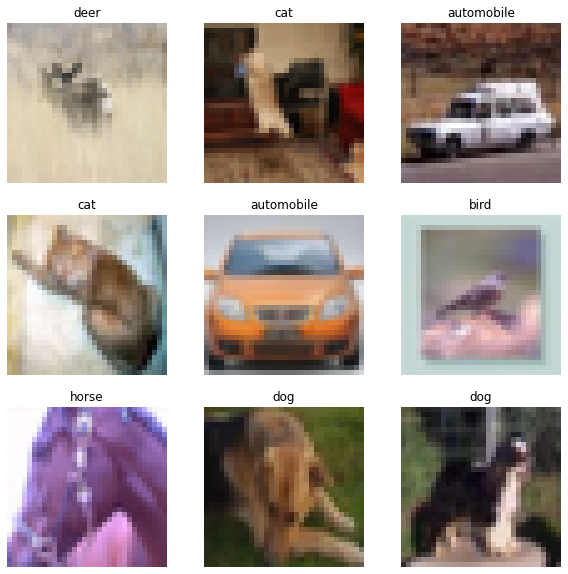

In [13]:
# plotting some images to view the data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 32, 32, 3)
(128,)


#### Using data augementation to double the training set size

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(
    height_factor=0.1,
    width_factor=0.1,
    fill_mode='reflect',
    interpolation='bilinear',
    seed=42,
    fill_value=0.0,
),
 tf.keras.layers.Resizing(32, 32)
])


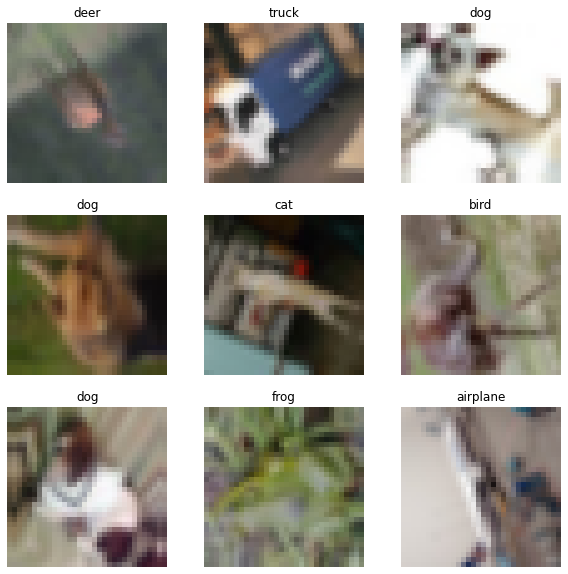

In [16]:
#Without normalization
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images[i])
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image.numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
            num_parallel_calls=AUTOTUNE)
len(ds)

In [18]:
train_ds = train_ds.concatenate(ds)
len(train_ds)

626

### Creating the Model

In [19]:
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [20]:
# Training parameters 
# Representative and not actually used , epochs are distribute on several runs due to limited resources and keras inefficiency
BATCH_SIZE = 128
EPOCHS = 200
NUM_CLASSES = 10

#### The residual block used by the model


In [21]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    # conv1x1 or conv3x3 depending on call
    conv = Conv2D(num_filters,
                kernel_size=kernel_size,
                strides=strides,
                padding='same',
                kernel_initializer='he_normal',
                kernel_regularizer=l2(1e-4))
    
    # check where conve is actually added
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

#### model uses batch norm SWISH activation for all but first layer

In [22]:
def resnet(input_shape, depth, dropout, num_classes=10):
    # make sure the given depth is valid
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
   
    # Calculate number of Residual Blocks
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # first layer
    x = resnet_layer(inputs=inputs,
                    num_filters=num_filters_in,
                    conv_first=True)
    
    # Creating the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'swish'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2 
    
            # Adding the 3 conv layers with dropouts in between
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = tf.keras.layers.Dropout(dropout)(y)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = tf.keras.layers.Dropout(dropout)(y)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            
            if res_block == 0:
                # use conv1x1 to match the dimensions
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Create and return model
    model = Model(inputs=inputs, outputs=outputs)
    return model

#### Creating learning rate schedular

In [23]:
# Scheduler used inside the model to change the learning rate
def sched(epoch, lr):
    lr = 1e-3
    if epoch > 50:
        lr *= 0.5e-3
    elif epoch > 40:
        lr *= 1e-3
    elif epoch > 30:
        lr *= 1e-2
    elif epoch > 20:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

### Model Creation and compilation

In [24]:
input_shape = (32,32,3)
model = resnet(input_shape,56,0.5)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(lr=sched(0, 0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch

### First Run
> run for 60 epochs and save checkpoints

In [ ]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/MyDrive/kaggle/cifar/model/cifar.h5', monitor='val_accuracy', save_best_only=True)

start_time = time.time()

# Scheduler used inside the model to change the learning rate
def sched(epoch, lr):
    lr = 1e-3
    if epoch > 50:
        lr *= 0.5e-3
    elif epoch > 40:
        lr *= 1e-3
    elif epoch > 30:
        lr *= 1e-2
    elif epoch > 20:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
    
# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(sched)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler, checkpoint]

In [ ]:
model.fit(train_ds,
              batch_size=BATCH_SIZE,
              epochs=60,
              validation_data=val_ds,
              shuffle=True,
              callbacks=callbacks)

Learning rate:  0.001
Epoch 1/60
626/626 [==============================] - 145s 218ms/step - loss: 2.3078 - accuracy: 0.4181 - val_loss: 1.9531 - val_accuracy: 0.4859 - lr: 0.0010
Learning rate:  0.001
Epoch 2/60
626/626 [==============================] - 134s 212ms/step - loss: 1.7198 - accuracy: 0.5348 - val_loss: 1.6276 - val_accuracy: 0.5525 - lr: 0.0010
Learning rate:  0.001
Epoch 3/60
626/626 [==============================] - 133s 211ms/step - loss: 1.5102 - accuracy: 0.5831 - val_loss: 1.7099 - val_accuracy: 0.5028 - lr: 0.0010
Learning rate:  0.001
Epoch 4/60
626/626 [==============================] - 132s 209ms/step - loss: 1.3779 - accuracy: 0.6173 - val_loss: 1.8462 - val_accuracy: 0.4832 - lr: 0.0010
Learning rate:  0.001
Epoch 5/60
626/626 [==============================] - 135s 214ms/step - loss: 1.2788 - accuracy: 0.6479 - val_loss: 1.4082 - val_accuracy: 0.6043 - lr: 0.0010
Learning rate:  0.001
Epoch 6/60
626/626 [==============================] - 131s 208ms/step - l

### Second Run:
> run another 30 epochs with different schedular

In [ ]:
def sched(epoch, lr):
    lr = 1e-4
    if epoch > 25:
        lr *= 0.5e-2
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# Save old model weights to be called next
model.save('/content/drive/MyDrive/kaggle/cifar/model/cifar2.h5')
# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(sched)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [ ]:
input_shape = (32,32,3)
model = resnet(input_shape,56,0.2)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(lr=sched(0, 0)),
              metrics=['accuracy'])

model.load_weights('/content/drive/MyDrive/kaggle/cifar/model/cifar2.h5')

callbacks = [lr_reducer, lr_scheduler, checkpoint]

model.fit(train_ds,
              batch_size=BATCH_SIZE,
              epochs=30,
              validation_data=val_ds,
              shuffle=True,
              callbacks=callbacks)
model.save('/content/drive/MyDrive/kaggle/cifar/model/cifar2.h5')

Learning rate:  0.0001
Learning rate:  0.0001
Epoch 1/30
626/626 [==============================] - 147s 217ms/step - loss: 0.5751 - accuracy: 0.8713 - val_loss: 0.6959 - val_accuracy: 0.8335 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 2/30
626/626 [==============================] - 134s 213ms/step - loss: 0.5628 - accuracy: 0.8758 - val_loss: 0.6894 - val_accuracy: 0.8326 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 3/30
626/626 [==============================] - 140s 222ms/step - loss: 0.5522 - accuracy: 0.8780 - val_loss: 0.6747 - val_accuracy: 0.8389 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 4/30
626/626 [==============================] - 148s 234ms/step - loss: 0.5459 - accuracy: 0.8802 - val_loss: 0.7065 - val_accuracy: 0.8282 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 5/30
626/626 [==============================] - 132s 210ms/step - loss: 0.5386 - accuracy: 0.8813 - val_loss: 0.6798 - val_accuracy: 0.8342 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 6/30
626/626 [====

### Third Run
> final 6 epochs 


In [29]:
input_shape = (32,32,3)
dropout = 0.1

for i in range(3):
    model = resnet(input_shape,56,dropout)
    dropout = dropout/2

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=Adam(lr=sched(0, 0)),
                metrics=['accuracy'])
    model.load_weights('/content/drive/MyDrive/kaggle/cifar/model/cifar3.h5')
    callbacks = [lr_reducer, lr_scheduler, checkpoint]

    model.fit(train_ds,
                batch_size=BATCH_SIZE,
                epochs=2,
                validation_data=val_ds,
                shuffle=True,
                callbacks=callbacks)
    model.save('/content/drive/MyDrive/kaggle/cifar/model/cifar3.h5')

Learning rate:  1e-05
Learning rate:  1e-05
Epoch 1/2
626/626 [==============================] - 210s 267ms/step - loss: 0.4285 - accuracy: 0.9159 - val_loss: 0.5801 - val_accuracy: 0.8729 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 2/2
626/626 [==============================] - 163s 259ms/step - loss: 0.4250 - accuracy: 0.9168 - val_loss: 0.5815 - val_accuracy: 0.8725 - lr: 1.0000e-05


Learning rate:  1e-05
Learning rate:  1e-05
Epoch 1/2
626/626 [==============================] - 210s 267ms/step - loss: 0.4007 - accuracy: 0.9253 - val_loss: 0.5792 - val_accuracy: 0.8720 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 2/2
626/626 [==============================] - 166s 264ms/step - loss: 0.3945 - accuracy: 0.9275 - val_loss: 0.5715 - val_accuracy: 0.8737 - lr: 1.0000e-05


Learning rate:  1e-05
Learning rate:  1e-05
Epoch 1/2
626/626 [==============================] - 205s 261ms/step - loss: 0.3838 - accuracy: 0.9308 - val_loss: 0.5819 - val_accuracy: 0.8685 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 2/2
626/626 [==============================] - 165s 263ms/step - loss: 0.3817 - accuracy: 0.9315 - val_loss: 0.5800 - val_accuracy: 0.8693 - lr: 1.0000e-05


## Testing
Testing is done using the kaggle provided test set, so cannot get the actual accuracies for the model. Could have used train, validation and test splits for this but the purpose of this notebook is to implement the resnet and not the classification model itself

In [ ]:
test_images = glob.glob('test/*')
test_images

[]

In [ ]:
data_dir= 'test'
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels=None,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
# Load model from drive
input_shape = (32,32,3)
model = resnet(input_shape,56,0.5)
model.load_weights('/content/drive/MyDrive/kaggle/cifar/model/cifar3.h5')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    plt.axis("off")